In [74]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.5.0


In [76]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [60]:
img_height = 72
img_width = 72
batch_size = 32

In [61]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode = "int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.01,
    subset="training",
)

Found 39364 files belonging to 275 classes.
Using 38971 files for training.


In [62]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'valid',
    labels='inferred',
    label_mode = "int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.8,
    subset="validation",
)

Found 1375 files belonging to 275 classes.
Using 1100 files for validation.


In [63]:
class_names = ds_train.class_names
print(class_names)

['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED REEDLING', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK & YELLOW bROADBILL', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED BUSHTIT', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BORNEAN BRISTLEHEAD', 'BORNEAN LEAFBIRD', 'BROWN NOODY', 'BROWN THRASHER', 'BULWERS PHEASANT', 'CACTUS WREN', 'CALIFORNIA CONDOR', '

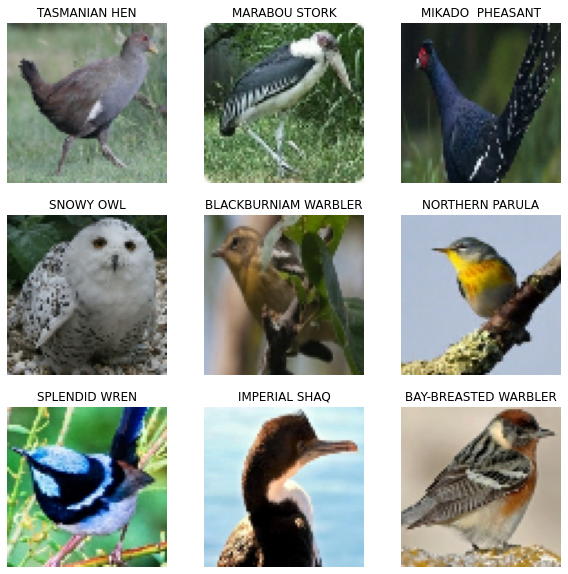

In [64]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [65]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 72, 72, 3)
(32,)


In [66]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.cache().prefetch(buffer_size=AUTOTUNE)

In [68]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [69]:
normalized_ds = ds_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [70]:
num_classes = 275

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Conv2D(64, 1, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, 'sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.004)
loss=tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
  optimizer=opt,
  loss=loss,
  metrics=['accuracy'])

In [71]:
model.fit(
  normalized_ds,
  validation_data=ds_validation,
  epochs=1
)

1218/1218 [==============================] - 82s 64ms/step - loss: 5.6104 - accuracy: 0.0051 - val_loss: 8.7104 - val_accuracy: 0.0055
